In [1]:
import re, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Circle
import pandas as pd
import datetime
import math
from pathlib import Path
xlims = [-5, 5]
ylims = [-5, 5]
BACKGROUND_ANGLES = (150, 120, 90, 60)
STEREO_COLS = ['date','unix_time', 'Nevent_1', 'Nevent_2', 'size_1', 'size_2', 'dist_1', 'dist_2',
       'zenith', 'azimuth', 'CR_stereo', 'xc_1', 'yc_1', 'xc_2', 'yc_2', 'a_1',
       'b_1', 'a_2', 'b_2', 'Xint', 'Yint', 'theta_int', 'Xground', 'Yground', 'nwidth',
       'errorON', 'source_x', 'source_y', "status"]
# BACKGROUND_ANGLES = []
iact01_delay = 1.490 #us
iact02_delay = 2.040 #us
CIRCLE_CUT = 0.2
SIZE_CUT = 120
DIST_CUT = 3.5
ZENITH_CUT = 30
ZENITH_CUT1 = 40
Nbins = 100
tel_coord =[[108.52, -35.52], [91.3, -197.15], [1.01, 1.55]] #First -- Xs, Second -- Ys

def sigma(ON, OFF, n = 1):
    
    if type(OFF) == type(np.array([3])):
        if ON + any(OFF):
            return (ON - np.mean(OFF)) / np.sqrt(ON + np.mean(OFF) / len(OFF))
        else:
            return 0
    elif type(OFF) == type(3.):
        if ON + OFF:
            return (ON - OFF) / np.sqrt(ON + OFF / n)
        else:
            return 0

In [15]:
## stereo_joint_events

def time(timestamp):
    value = datetime.datetime.fromtimestamp(timestamp, tz=datetime.timezone.utc)
    milli, micro = value.strftime('%f')[0:3], value.strftime('%f')[2:-1]
    return value.strftime('%H:%M:%S,')+".".join([milli, micro, "000"])

def timestamp(eventtime, date = datetime.date(2019, 11, 23)):
    t, m = eventtime.split(",")
    datestr = datetime.date.strftime(date, "%d.%m.%Y ")
    m = ','+''.join(m.split(".")[:-1])
    result = datetime.datetime.timestamp(datetime.datetime.strptime(datestr + t + m, "%d.%m.%Y %H:%M:%S,%f"))
    return result

def delta(time1, time2):
    #12:34:56,789.101.112
    t1, t1m = time1.split(",")
    t1 = list(map(int, t1.split(":")))
    t1m = list(map(int, t1m.split(".")))
    t2, t2m = time2.split(",")
    t2 = list(map(int, t2.split(":")))
    t2m = list(map(int, t2m.split(".")))
    
    dt = [t2[i] - t1[i] for i in range(3)]
    dtm = [t2m[i] - t1m[i] for i in range(3)]
    
    dt = 3600*dt[0]+60*dt[1]+dt[2] * 1e6
    dtm = (1000000*dtm[0]+1000*dtm[1]+dtm[2]) * 1e-3
    return abs(dt+dtm) #us

def timeshift(df1, df2, i, j):
    time1 = time(int(df1["unix_time"].iloc[i]))
    time2 = time(int(df2["unix_time"].iloc[j]))
    #WARNING ONLY FOR IACT01 & 02
    timens1 = '{:09}'.format(df1["unix time after dot(ns)"].iloc[i] + int(1e3 * iact01_delay))
    timens2 = '{:09}'.format(df2["unix time after dot(ns)"].iloc[j] + int(1e3 * iact02_delay))
    timens1 = timens1[0:3]+'.'+timens1[3:6]+'.'+timens1[6:9]
    timens2 = timens2[0:3]+'.'+timens2[3:6]+'.'+timens2[6:9]
    time1 = ','.join([time1.split(",")[0], timens1])
    time2 = ','.join([time2.split(",")[0], timens2])
#     print(time1, time2)
    return(delta(time1, time2))


def joint2(df1, df2, delta = 50): #us
    i, j = 0, 0
    pairs = []
    
    e1 = np.array(df1["unix_time"]).astype(int)# + np.array(df1["unix time after dot(ns)"]) * 1e-9
    e2 = np.array(df2["unix_time"]).astype(int)# + np.array(df2["unix time after dot(ns)"]) * 1e-9
    if (len(e1) == 0) or (len(e2) == 0):
        return e1, e2, pairs, []
    run_time = (min(e1[-1], e2[-1]) - max(e1[0], e2[0]))
    stereo_rates = np.zeros(int(run_time / 30))
    
    z = max(e1[0], e2[0])
    e1 -= z
    e2 -= z
    e1 = e1.astype("float64")
    e2 = e2.astype("float64")
    e1 += np.array(df1["unix time after dot(ns)"], dtype = "int32") * 1e-9
    e2 += np.array(df2["unix time after dot(ns)"], dtype = "int32") * 1e-9
    e1 += iact01_delay * 1e-6
    e2 += iact02_delay * 1e-6
    if e1[i] < e2[j]:
        while (e1[i] < e2[j]):
            i += 1
    elif e1[i] > e2[j]:
        while (e1[i] > e2[j]):
            j += 1
    if abs(e1[i] - e2[j]) * 1e6 <= delta:
        pairs.append((i, j, 1e6*abs(e1[i] - e2[j])))
        i += 1
        j += 1
#     print(i, j, abs(e1[i] - e2[j]) * 1e6)
    for i1 in range(i, len(e1)):
        if j >= len(e2) - 1:
            break
        while (abs(e1[i1] - e2[j]) * 1e6 > delta):
            if e2[j] < e1[i1]:
                j += 1
#                 print(i1, j)
            else:
                break
            if j == len(e2)-1:
                break
        else:
#             print(i1, j)
            pairs.append((i1, j, 1e6 * (e1[i1] - e2[j])))
            if int(e1[i1] / 30) < len(stereo_rates) - 1:
                stereo_rates[int(e1[i1] / 30)] += 1
            else:
                stereo_rates[-1] += 1
        
    return e1, e2, pairs, stereo_rates

months = ['aug20', 'sep20', 'oct20', "nov20", "dec20", "sep21", "oct21", "nov21"]
# months = ['crab20']
months = ['aug20', 'sep20', 'oct20', 'nov20', 'dec20']
# months = ["oct21", "nov21"]
deltas = []
iact1_time = 0
iact2_time = 0
MODE = 0 #0 for low zenith angles, 1 for big zenith angles
for month in months:
    dates = set([d[:-3] for d in os.listdir('/'.join(['IACT01', month, '']))]) & set([d[:-3] for d in os.listdir('/'.join(['IACT02', month, '']))])
#     dates = ["271021"]
    for date in dates:
        PATH1 = '/'.join(['IACT01', month, ''])
        Runs1 = [f for f in os.listdir(PATH1) if f.startswith(date)]
        PATH2 = '/'.join(['IACT02', month, ''])
        Runs2 = [f for f in os.listdir(PATH2) if f.startswith(date)]
    #     files = [f for f in os.listdir(PATH1) if f.endswith('.txt')]
        hillas_files1 = []
        hillas_files2 = []
        for run in Runs1:
            files = os.listdir(PATH1 + run + '/')
            hillas_files1 += [PATH1 + run + '/' + f for f in files if f.endswith('.csv')]
            print(hillas_files1)
        for run in Runs2:
            files = os.listdir(PATH2 + run + '/')
            hillas_files2 += [PATH2 + run + '/' + f for f in files if f.endswith('.csv')]
            print(hillas_files2)
    #     hillas_files1 = [PATH1 + PATH + '/' + f for f in  if (PATH1 + PATH + '/' + f).endswith('.csv')][0]
    #     hillas_files2 = [PATH2 + PATH + '/' + f for f in [os.listdir(PATH2 + PATH + '/') for PATH in Runs2] if (PATH2 + PATH + '/' + f).endswith('.csv')][0]

        df1 = pd.concat([pd.read_csv(f) for f in hillas_files1])
        df1 = df1.rename(columns = {col:col.strip() for col in df1.columns})
        # {col:col.strip() for col in df.columns}
        df2 = pd.concat([pd.read_csv(f) for f in hillas_files2])
        df2 = df2.rename(columns = {col:col.strip() for col in df2.columns})
        iact1_time += df1["unix_time"].iloc[-1] - df1["unix_time"].iloc[0]
        iact2_time += df2["unix_time"].iloc[-1] - df2["unix_time"].iloc[0]
        #zenith_cut
        if MODE == 1:
            print(90 - np.mean(df1["source_el"]))
            df1 = df1[(df1["source_el"] < (90 - ZENITH_CUT))]
            df2 = df2[(df2["source_el"] < (90 - ZENITH_CUT))]
            df1 = df1[(df1["source_el"] > (90 - ZENITH_CUT1))]
            df2 = df2[(df2["source_el"] > (90 - ZENITH_CUT1))]
            print(90 - np.mean(df1["source_el"]))
        else:
            df1 = df1[(df1["source_el"] > (90 - ZENITH_CUT))]
            df2 = df2[(df2["source_el"] > (90 - ZENITH_CUT))]
        
        if not month in os.listdir('joint'+'_za'*MODE): os.mkdir("joint"+'_za'*MODE+ "/"+month)

        e1, _, join, rates = joint2(df1, df2, delta = 1)
        if len(join):
            fout = open("joint"+'_za'*MODE+"/"+month+'/'+ "joint" + date + ".txt", "w")
            for i, j, d in join:
                index = int(e1[i] / 30)
                try:
                    print(i, j, "{:.2f}".format(rates[index] / 30), file = fout)
#                     print(int(df1.iloc[i]["event_numb"]), int(df2.iloc[j]["event_numb"]), "{:.2f}".format(rates[index] / 30), file = fout)
                except IndexError:
                    print(i, j, "{:.2f}".format(rates[index - 1] / 30), file = fout)
#                     print(int(df1.iloc[i]["event_numb"]), int(df2.iloc[j]["event_numb"]), "{:.2f}".format(rates[index - 1] / 30), file = fout)
                deltas.append(d)
            print(len(df1), len(df2), len(join), len(join)/np.mean((len(df1), len(df2))))
            fout.close()
#             plt.plot(rates)
# plt.hist(deltas, log = True, bins = Nbins // 2)
# plt.xlim(-2, 2)


['IACT01/aug20/220820.01/220820.01_out_hillas_06_03sig.csv']
['IACT01/aug20/220820.01/220820.01_out_hillas_06_03sig.csv', 'IACT01/aug20/220820.02/220820.02_out_hillas_06_03sig.csv']
['IACT02/aug20/220820.02/220820.02_out_hillas_06_03sig.csv']
70828 81386 8426 0.11071254943697689
['IACT01/aug20/180820.00/180820.00_out_hillas_06_03sig.csv']
['IACT02/aug20/180820.03/180820.03_out_hillas_06_03sig.csv']
['IACT02/aug20/180820.03/180820.03_out_hillas_06_03sig.csv', 'IACT02/aug20/180820.05/180820.05_out_hillas_06_03sig.csv']
41306 7643 917 0.03746756828535823
['IACT01/aug20/230820.00/230820.00_out_hillas_06_03sig.csv']
['IACT02/aug20/230820.01/230820.01_out_hillas_06_03sig.csv']
19410 70808 2543 0.05637455940056308
['IACT01/aug20/190820.00/190820.00_out_hillas_06_03sig.csv']
['IACT02/aug20/190820.03/190820.03_out_hillas_06_03sig.csv']
96352 57307 5724 0.07450263245237831
['IACT01/aug20/200820.01/200820.01_out_hillas_06_03sig.csv']
['IACT02/aug20/200820.03/200820.03_out_hillas_06_03sig.csv']
87

In [39]:
df2

,por,event_numb,unix_time,unix time after dot(ns),delta_time,error_deg,tel_az,tel_el,source_az,source_el,...,tel_ra,tel_dec,source_ra,source_dec,source_x,source_y,tracking,good,star,edge
204577,4,286530,1.636289e+09,753290880,0.25,0.03,253.26195,60.892,254.87924,59.999,...,306.43,36.8,304.94,36.8,6.56,7.67,1,1,1,0
204578,4,286533,1.636289e+09,759063990,0.24,0.03,253.26195,60.892,254.87924,59.999,...,306.43,36.8,304.94,36.8,6.56,7.67,1,1,0,1
204579,4,286535,1.636289e+09,762426690,0.24,0.03,253.26195,60.892,254.87924,59.999,...,306.43,36.8,304.94,36.8,6.56,7.67,1,1,1,1
204580,4,286538,1.636289e+09,769524800,0.23,0.03,253.26195,60.892,254.87924,59.999,...,306.43,36.8,304.94,36.8,6.56,7.67,1,1,0,1
204581,4,286539,1.636289e+09,770754310,0.23,0.03,253.26195,60.892,254.87924,59.999,...,306.43,36.8,304.94,36.8,6.56,7.67,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1102773,22,1550859,1.636293e+09,242353480,0.24,0.03,270.88607,49.077,269.70649,50.001,...,303.44,36.8,304.94,36.8,-6.15,-8.03,1,1,0,0
1102774,22,1550861,1.636293e+09,245774150,0.25,0.03,270.88607,49.077,269.70649,50.001,...,303.44,36.8,304.94,36.8,-6.15,-8.03,1,1,0,0
1102775,22,1550862,1.636293e+09,246625210,0.25,0.03,270.88607,49.077,269.70649,50.001,...,303.44,36.8,304.94,36.8,-6.15,-8.03,1,1,0,0
1102776,22,1550863,1.636293e+09,247062800,0.25,0.03,270.88607,49.077,269.70649,50.001,...,303.44,36.8,304.94,36.8,-6.15,-8.03,1,1,0,0


In [16]:
iact1_time/3600, iact2_time/3600

(56.61090079307556, 54.42456147339609)

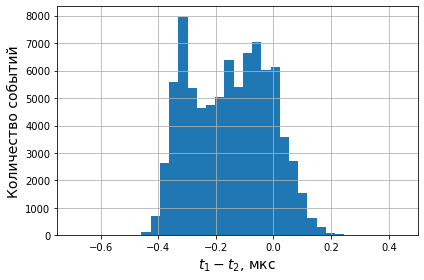

In [21]:
plt.hist(deltas, bins=60)
plt.xlim(-0.75, 0.5)
plt.grid()
plt.xlabel(r"$t_1-t_2$, мкс", fontsize=14)
plt.ylabel("Количество событий", fontsize=14)
plt.tight_layout()
plt.savefig("iactDeltas.png", dpi=500)

In [ ]:
joint = [[] for i in range(2)]

for i, j, _ in join: #пока для двух телескопов тут ещё записывается задержка
#         print(s)
    joint[0].append(i)
    joint[1].append(j)
dfs = [df1, df2]
cuts = [dfs[tel].iloc[joint[tel]] for tel in range(2)]
cuts[1]

In [ ]:
df2["event_numb"]

In [91]:
#0 North
#90 East
#180 South
#270 West

def multi_background(x, y, phi):
    angle = np.radians(phi)
    x1 = x * np.cos(angle) - y * np.sin(angle)
    y1 = x * np.sin(angle) + y * np.cos(angle)
    x2 = x * np.cos(angle) + y * np.sin(angle)
    y2 = -x * np.sin(angle) + y * np.cos(angle)
    return (x1, y1), (x2, y2)

class PoV():
    def __init__(self, Ntel = 0, Npix = 0, 
                 size = 0, dist = 0, bound = 0,
                 a = 0, b = 0, alpha = 0, width = 0, xc = 0, yc = 0, length = 0, tel_theta = 0, tel_phi = 270):
        self.Ntel = Ntel
        self.Npix = Npix
        self.size = size
        self.dist = dist
        self.bound = bool(bound)
        self.a = a
        self.b = b
        
        self.alpha = alpha
        self.width = width#/ 0.1206
        self.xc = xc #/ 0.1206
        self.yc = yc #/ 0.1206
        self.length = length#/ 0.1206
        self.tel_theta = tel_theta
        self.tel_phi = tel_phi
    def core(self):
        return self.Ntel, self.size

class MCEvent():
    def __init__(self, Nevent = 1,
                 tel_theta = 0, tel_phi = 0, src_theta = 0, src_phi = 0, 
                 source_x = 0, source_y = 0):
        self.Nevent = Nevent
        
        self.src_theta = src_theta
        self.src_phi = src_phi
        self.Ntrig = 0
        self.x = source_x
        self.y = source_y
        self.data = [None for i in range(5)]
    def add(self, pov = PoV()):
        self.data[pov.Ntel] = pov
        self.Ntrig += 1
    def count(self):
        z = 0
        for pov in self.data:
            if pov:
                z += 1
        return z
    def vizualize(self, colors = ['r', 'y', 'g', 'c', 'b', 'm', 'k'], alpha = 0.3, pixel_coords = None):
        #alpha = 0.3 #параметр для нормирования прозрачности
        fig, ax = plt.subplots(figsize=(7,7), dpi=500)
        
        # ax.set_title("#"+super().Nevent+"   "+str(self.time), fontsize=16)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
        plt.rcParams.update({'font.size': 14})
        xes = np.linspace(-5, 5, 20)
        # ax.scatter(self.source_x, self.source_y, marker = "*", c = "red")
        for pov in self.data:
            if pov:
                ax.plot(xes, pov.a * xes + pov.b, ":m")
                ellipse = Ellipse((pov.xc, pov.yc), 
                                      4 * pov.length,
                                      4 * pov.width, angle = np.degrees(np.arctan(pov.a)),
                                  color = "r", alpha = 0.5)
#                 print('{:.3}, {:.3}, {:.3}, {:.3}'.format(pov.xc, pov.yc, pov.a, pov.b))
                ax.add_artist(ellipse)
                ax.text(pov.xc, pov.yc, "IACT0"+str(pov.Ntel+1), fontsize=12)
            # print(ellipse)
        ax.scatter(self.x, self.y, marker = '*', c = 'r')
        ist_circle = Circle((self.x, self.y), radius = CIRCLE_CUT, fill = False, color = "red")
        ax.add_artist(ist_circle)
        ax.scatter(-self.x, -self.y, marker = '*', c = 'black')
        sources = [(-self.x, -self.y)]
        for angle in BACKGROUND_ANGLES:
            sources += [*multi_background(self.x, self.y, angle)]
#         print(sources)
        for source in sources:
            circle = Circle(source, radius = CIRCLE_CUT, fill = False, color = "black")
            ax.add_artist(circle)
            ax.scatter(source[0], source[1], marker = '*', c = 'black')
            
        
#         if self.count() == 2:
#             pov1, pov2 = [pov for pov in self.data if pov]
#             X, Y, theta = intersect(pov1, pov2)
#             print(X, Y, theta)
        if self.count() > 2:
            X, Y = mean_intersect(self)
            print("Intersect at", "{:.3f} {:.3f}".format(X, Y))
            print("Axis determination error is", "{:.3f}".format(eudist((X, Y), (self.x, self.y))))
            ax.scatter(X, Y, marker = '*', c = 'm')
        elif self.count() == 2:
            pov1, pov2 = [pov for pov in self.data if pov]
#             print(povs)
            X, Y, _ = intersect(pov1, pov2)
            print("Source at", "{:.3f} {:.3f}".format(self.x, self.y))
            print("Intersect at", "{:.3f} {:.3f}".format(X, Y))
            print("Axis determination error is", "{:.3f}".format(eudist((X, Y), (self.x, self.y))))
            ax.scatter(X, Y, marker = '*', c = 'm')
            
        if pixel_coords is not None:
            plt.scatter(pixel_coords[pixel][1], pixel_coords[pixel][2], color = colors[(pixel_coords[pixel][0]-1)%7], alpha = 0.1)
        return ax


def eudist(a1, a2):
    return np.sqrt((a1[0] - a2[0])**2 + (a1[1] - a2[1])**2)
def intersect(pov1, pov2):
    vec1 = np.array((1, pov1.a))
    vec2 = np.array((1, pov2.a))
    def length(vec):
        return np.sqrt(vec[0] ** 2 + vec[1] ** 2)
    X = (pov2.b - pov1.b)/(pov1.a - pov2.a)
#     print(X)
    Y = pov1.a * X + pov1.b
    theta = np.arccos(np.sum(vec1 * vec2 / length(vec1) / length(vec2)))
    return (X, Y, np.degrees(theta))

def sph2cart(az, el, r):
    rcos_theta = r * np.cos(el)
    x = rcos_theta * np.cos(az)
    y = rcos_theta * np.sin(az)
    z = r * np.sin(el)
    return x, y, z

def get_trans_matrix(azimuth, zen):
    """Get Transformation matrix for conversion from the ground system to
    the Tilted system and back again (This function is directly lifted
    from read_hess, probably could be streamlined using python
    functionality)

    Parameters
    --------
    azimuth: float
    Azimuth angle of the tilted system used
    zen: float
    Zenit angle of the tilted system used

    Returns
    -----
    trans: 3x3 ndarray transformation matrix
    """

    
    
    v = sph2cart(np.radians(90) + azimuth, 0, 1)
    trans = np.array([[(np.cos(zen) + (1 - np.cos(zen))*(v[0] ** 2)) , ((1 - np.cos(zen))*v[0]*v[1] - np.sin(zen)*v[2]), ((1 - np.cos(zen))*v[0]*v[2] + np.sin(zen)*v[1])],
    [((1 - np.cos(zen))*v[1]*v[0] + np.sin(zen)*v[2]), (np.cos(zen) + (1 - np.cos(zen))*(v[1] ** 2)), ((1 - np.cos(zen))*v[1]*v[2] - np.sin(zen)*v[0])],
    [((1 - np.cos(zen))*v[2]*v[0] - np.sin(zen)*v[1]), ((1 - np.cos(zen))*v[2]*v[1] + np.sin(zen)*v[0]), (np.cos(zen) + (1 - np.cos(zen))*(v[2] ** 2))]])

    return trans

def ground_intersect(pov1, pov2, tel_coord):
    vec1 = np.array((1, pov1.a))
    vec2 = np.array((1, pov2.a))
    povs = (pov1, pov2)
    tel_coord_tilted = [[0 for i in range(2)] for j in range(3)]
    for (i_tel, pov) in enumerate(povs):
        zen = np.radians(pov.tel_theta)
        azimuth = np.radians(pov.tel_phi)
        normal = sph2cart(azimuth, np.pi/2 - zen, 1)
        M = get_trans_matrix(azimuth, zen)
        t = (-normal[0]*tel_coord[0][i_tel]-normal[1]*tel_coord[1][i_tel]-normal[2]*tel_coord[2][i_tel])/(normal[0] ** 2 + normal[1] ** 2 + normal[2] ** 2)
        tel_coord_tilted[0][i_tel] = M[0][0] * (tel_coord[0][i_tel]+t*normal[0]) + M[1][0] * (tel_coord[1][i_tel]+t*normal[1]) + M[2][0] * (tel_coord[0][i_tel]+t*normal[2])
        tel_coord_tilted[1][i_tel] = M[0][1] * (tel_coord[0][i_tel]+t*normal[0]) + M[1][1] * (tel_coord[1][i_tel]+t*normal[1]) + M[2][1] * (tel_coord[2][i_tel]+t*normal[2])
        tel_coord_tilted[2][i_tel] = M[0][2] * (tel_coord[0][i_tel]+t*normal[0]) + M[1][2] * (tel_coord[1][i_tel]+t*normal[1]) + M[2][2] * (tel_coord[2][i_tel]+t*normal[2])
#     normal = sph2cart(np.radians(pov1.tel_phi), np.pi/2 - np.radians(pov1.tel_theta), 1)
# #     print(normal)
#     
#     for i in range(2):
# #         D = -normal[0] * tel_coord[0][i]
#         t = -(normal[0] * tel_coord[0][i] + normal[1] * tel_coord[1][i])/(normal[0] ** 2 + normal[1] ** 2 + normal[2] ** 2)
#         tel_coord_tilted[0][i] = normal[0] * t + tel_coord[0][i]
#         tel_coord_tilted[1][i] = normal[1] * t + tel_coord[1][i]
#         tel_coord_tilted[2][i] = normal[2] * t
# #     print(tel_coord + [[0, 0]])
# #     print(tel_coord_tilted)
    b1 = tel_coord_tilted[0][1] - pov1.a * tel_coord_tilted[0][0]
    b2 = tel_coord_tilted[1][1] - pov1.a * tel_coord_tilted[1][0]
    def length(vec):
        return np.sqrt(vec[0] ** 2 + vec[1] ** 2)
    X = (b2 - b1)/(pov1.a - pov2.a)
#     print(X)
    Y = pov1.a * X + b1
    theta = np.arccos(np.sum(vec1 * vec2 / length(vec1) / length(vec2)))
    return (X, Y, tel_coord_tilted)


def norm_width(scalewidth, povs, tel_coord, x_ground, y_ground):
    nwidth = 0
    normalize = 0
    tel_coord = np.array(tel_coord)
    hillas = np.array(povs)
    for j in range(len(povs)):
        find_nwidth = 0
        distance = np.sqrt((x_ground - tel_coord[j][0]) ** 2 + (y_ground - tel_coord[j][1]) ** 2)
        for i, (d1, d2) in enumerate(zip(scalewidth['d1'],scalewidth['d2'])):
            if(distance >= d1 and distance < d2):
                find_nwidth = 1
                normalize += 1
                size_event = povs[j].size
                width_event = povs[j].width
                med = scalewidth['k_tab'][i]*pow(size_event, scalewidth['g_tab'][i]);
                MADmed = scalewidth['a_tab'][i]*size_event + scalewidth['b_tab'][i];
                nwidth = nwidth + (width_event - med)/(MADmed)
        if (find_nwidth == 0 and distance >= scalewidth['d2'].iloc[-1]):
            normalize+=1
            size_event = povs[j].size
            width_event = povs[j].width
            med = scalewidth['k_tab'].iloc[-1]*pow(size_event, scalewidth['g_tab'].iloc[-1]);
            MADmed = scalewidth['a_tab'].iloc[-1]*size_event + scalewidth['b_tab'].iloc[-1];
            nwidth = nwidth + (width_event - med)/(MADmed)
    if(normalize > 0):
        if(abs(nwidth/normalize) < 20):
            return nwidth/normalize
        else:
            return None
    else:
        return None
    
scalewidth = pd.read_csv('MAD_params_new.txt', sep="\s+", header=None);
scalewidth.columns = ["d1", "d2", "k_tab", "g_tab", "a_tab", "b_tab"]    

In [ ]:
dfs[0].columns

In [10]:


def rotate(point, angle, origin = [0,0]):
    """
    Rotate a point counterclockwise by a given angle around a given origin.

    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def get_rot_axis(a,b,x0,y0,tet):
    a_new = np.tan(np.arctan(a) + tet)
    b_new = y0 - x0*a_new
    #print(a,b,a_new,b_new,tet)
    return(a_new, b_new)
focal = [485, 482]
def get_alpha(fi_t, tet_t, fi_s, tet_s, x_rot, y_rot, xc, yc, a_axis, b_axis, f, a = 0):
    fi_t = math.radians(fi_t) #по азимуту
    tet_t = math.radians(tet_t) #по высоте
    fi_s = math.radians(fi_s)
    tet_s = math.radians(tet_s)
    z = math.sin(tet_s)*math.sin(tet_t) + math.cos(tet_s)*math.cos(tet_t)*math.cos(fi_s - fi_t)
    x0shift = 0.1206*(f/z)*math.cos(tet_s)*math.sin(fi_s - fi_t)
    y0shift = 0.1206*(f/z)*(math.cos(tet_s)*math.sin(tet_t)*math.cos(fi_s - fi_t) - math.sin(tet_s)*math.cos(tet_t))
    alp = np.arctan2(x_rot, y_rot) - np.arctan2(x0shift, y0shift)
    #print(x0shift, y0shift, rotate([x_rot,y_rot], alp))
    xc_shift, yc_shift = rotate([xc,yc], alp)
    a_new, b_new = get_rot_axis(a_axis, b_axis,xc_shift, yc_shift,alp)
    return (x0shift,y0shift, xc_shift, yc_shift, a_new, b_new)

In [112]:
#MAIN


current_dir = Path.cwd()
iacts = [IACT.name for IACT in current_dir.glob("IACT*")]
dfs = [0] * len(iacts)
MODE = 1 #0 for little zenith angles
# date = "200820"
months = ["aug20", "sep20", "oct20", "nov20", "sep21", "oct21", "nov21"]
# months = ["crab20"]
current_dates = ["190820", "200820","220820", "160920", "180920", "131020", "181020", "211020", 
                 "221020", "111120", "171120", "041021", "051021", "061021", "091021", "291021", "011121", "071121"]
# current_dates = ["271021"]
# months = ["aug20"]

total_df = {col: [] for col in STEREO_COLS}
total_time = 0
total_cutted_ON = 0
total_cutted_OFF = np.zeros(1 + 2 * len(BACKGROUND_ANGLES))
total_events = 0
nwidths = []
events_selected = []
OFFpoints = dict()
mode_index = "1"
for month in months:
    for datename in list((current_dir /("joint"+MODE*"_za")/month).glob("*.txt")):
        date = re.findall("\d\d\d\d\d\d", datename.name)[0]
        eventsON, eventsOFF = 0, np.zeros(len(total_cutted_OFF))
#         if date not in current_dates:
#             continue
        for IACT in iacts:
            tel = int(re.findall("\d\d", IACT)[0]) - 1
            runs = [f.resolve(current_dir) for f in (current_dir / IACT /month).rglob("*" + date + "*.csv")]
            dfs[tel] = pd.concat([pd.read_csv(run) for run in runs])
            
            dfs[tel] = dfs[tel].rename(columns = {col:col.strip() for col in dfs[tel].columns})
            if MODE == 1:
                dfs[tel] = dfs[tel][(dfs[tel]["source_el"] < (90 - ZENITH_CUT))]
                dfs[tel] = dfs[tel][(dfs[tel]["source_el"] > (90 - ZENITH_CUT1))]
            else:
                dfs[tel] = dfs[tel][(dfs[tel]["source_el"] > (90 - ZENITH_CUT))]
            dfs[tel]["source_x"] *= 0.1206
            dfs[tel]["source_y"] *= 0.1206
            dfs[tel]["b_axis"] *= 0.1206
            dfs[tel]["shift"] = eudist((0, 0),
                                        (dfs[tel]["Xc[0]"], dfs[tel]["Yc[0]"]))

        jointfile = (current_dir /("joint"+MODE*"_za")/month).rglob("*"+date+".txt")
        joint = [[] for i in range(len(iacts))]
        rates = []
        for s in next(jointfile).read_text().split("\n")[:-1]:
            for tel, value in enumerate(s.split()): #пока для двух телескопов тут ещё записывается темп
        #         print(s)
                if tel < 2: joint[tel].append(int(value)) #костыль
                elif tel == 2:
                    rates.append(float(value))
        cuts = [pd.DataFrame(dfs[tel].iloc[joint[tel]]) for tel in range(2)]
        for tel in range(2):
            cuts[tel]["stereo_rate"] = np.array(rates)
#                 run_time = (min(np.array(cuts[0]["unix_time"])[-1], np.array(cuts[1]["unix_time"])[-1])
#                               - max(np.array(cuts[0]["unix_time"])[0], np.array(cuts[1]["unix_time"])[0]))
        run_time = 0
        time0 = cuts[0]["unix_time"].iloc[0]

        Nevents = len(cuts[0])
        for i in range(Nevents):
            prepovs = [table.iloc[i] for table in cuts]
            z = prepovs[0]
            if (z["unix_time"] - time0) < 60:
                run_time += (z["unix_time"] - time0)
            time0 = z["unix_time"]
            x_source_new, y_source_new, xc_new, yc_new, a_new, b_new = get_alpha(z['tel_az'],
                                                                z['tel_el'],
                                                                z['source_az'],
                                                                z['source_el'],
                                                                z['source_x'],
                                                                z['source_y'],
                                                                z['Xc[0]'],
                                                                z['Yc[0]'],
                                                                z['a_axis'],
                                                                z['b_axis'],
                                                                f = focal[0])
#                 print('{:.3}, {:.3}, {:.3}, {:.3}, {:.3}, {:.3}'.format(z['source_x'], z['source_y'], z['Xc[0]'], z['Yc[0]'],z['a_axis'], z['b_axis']))
#                 print('{:.3}, {:.3}, {:.3}, {:.3}, {:.3}, {:.3}'.format(x_source_new, y_source_new, xc_new, yc_new, a_new, b_new))
#                 print('{:.3}, {:.3}, {:.3}'.format(xc_new, yc_new, a_new * xc_new + b_new))
            e = MCEvent(Nevent = z.event_numb, 
                       src_theta = z.source_el, src_phi = z.source_az,
                       source_x = x_source_new, 
                       source_y = y_source_new)
            OFFpoints[0] = (-x_source_new, -y_source_new)
            nsource = 1
            for angle in BACKGROUND_ANGLES:
                source1, source2 = multi_background(x_source_new, y_source_new, angle)
                OFFpoints[nsource], OFFpoints[nsource + 1] = source1, source2
                nsource += 2
#                     if i == 1: print(1, MODE, e.x, e.y, x_source_new, y_source_new)
            pov1 = PoV(Ntel = 0, Npix = z.numb_pix, size = z["size"], dist = z["dist["+mode_index+"]"],
                       bound = z.edge, a = a_new, b = b_new, xc = xc_new, yc = yc_new,
                     width = z["width[0]"], length = z["length[0]"],
                     alpha = z["alpha["+mode_index+"]"], tel_theta = z.tel_el, tel_phi = z.tel_az)

            z = prepovs[1]
            x_source_new, y_source_new, xc_new, yc_new, a_new, b_new = get_alpha(z['tel_az'],
                                                                z['tel_el'],
                                                                z['source_az'],
                                                                z['source_el'],
                                                                z['source_x'],
                                                                z['source_y'],
                                                                z['Xc[0]'],
                                                                z['Yc[0]'],
                                                                z['a_axis'],
                                                                z['b_axis'],
                                                                f = focal[1])
#                 print('{:.3}, {:.3}, {:.3}, {:.3}, {:.3}, {:.3}'.format(z['source_x'], z['source_y'], z['Xc[0]'], z['Yc[0]'],z['a_axis'], z['b_axis']))
#                 print('{:.3}, {:.3}, {:.3}, {:.3}, {:.3}, {:.3}'.format(x_source_new, y_source_new, xc_new, yc_new, a_new, b_new))
#                 print('{:.3}, {:.3}, {:.3}'.format(xc_new, yc_new, a_new * xc_new + b_new))
            pov2 = PoV(Ntel = 1, Npix = z.numb_pix, size = z["size"], dist = z["dist["+mode_index+"]"],
                     bound = z.edge, a = a_new, b = b_new, 
                     xc = xc_new + (e.x - x_source_new), 
                     yc = yc_new + (e.y - y_source_new),
                     width = z["width[0]"], length = z["length[0]"],
                     alpha = z["alpha["+mode_index+"]"], tel_theta = z.tel_el, tel_phi = z.tel_az)
#                     if i == 1: print(2, MODE, e.x, e.y, x_source_new, y_source_new)
            e.add(pov1)
            e.add(pov2)

            X, Y, theta = intersect(pov1, pov2)

            ground_x, ground_y, tel_coord_tilted = ground_intersect(pov1, pov2, tel_coord)
            Nwidth = norm_width(scalewidth, (pov1, pov2), tel_coord, ground_x, ground_y)
            total_df["Nevent_1"] += [e.Nevent]
            total_df["unix_time"] += [prepovs[0]["unix_time"]]
            total_df["date"] += [date]
            total_df["Nevent_2"] += [z.event_numb]
            total_df["size_1"] += [pov1.size]
            total_df["size_2"] += [pov2.size]
            total_df["dist_1"] += [prepovs[0]["dist[0]"]]
            total_df["dist_2"] += [prepovs[1]["dist[0]"]]
            total_df["zenith"] += [90 - np.mean([prepovs[0]["source_el"], prepovs[1]["source_el"]])]
            total_df["azimuth"] += [np.mean([prepovs[0]["source_az"], prepovs[1]["source_az"]])]
            total_df["CR_stereo"] += [rates[i]]
            total_df["xc_1"] += [pov1.xc]
            total_df["yc_1"] += [pov1.yc]
            total_df["xc_2"] += [pov2.xc]
            total_df["yc_2"] += [pov2.yc]
            total_df["a_1"] += [pov1.a]
            total_df["b_1"] += [pov1.b]
            total_df["a_2"] += [pov2.a]
            total_df["b_2"] += [pov2.b]
            total_df["Xint"] += [X]
            total_df["Yint"] += [Y]
            total_df["theta_int"] += [theta]
            total_df["Xground"] += [ground_x]
            total_df["Yground"] += [ground_y]
            if Nwidth:
                total_df["nwidth"] += [Nwidth]
            else:
                total_df["nwidth"] += [np.NaN]
            total_df["source_x"] += [e.x]
            total_df["source_y"] += [e.y]
#                 ground_x, ground_y, _ = ground_intersect(pov1, pov2, tel_coord)
            errorON = eudist((X, Y), (e.x, e.y))
            
            errorOFF = np.array([eudist((X, Y), OFFpoints[i]) for i in range(len(OFFpoints))])
            status = -1
            if (errorON < CIRCLE_CUT):
                total_df["errorON"] += [errorON]
                status = 0
                total_df["status"] += [0]
            elif any(errorOFF < CIRCLE_CUT):
                for i in range(len(errorOFF)):
                    if errorOFF[i] < CIRCLE_CUT:
                        status =  i + 1
                        total_df["status"] += [i + 1]
                        total_df["errorON"] += [errorOFF[i]]
                        break
            else:
                total_df["errorON"] += [errorON]
                total_df["status"] += [-1]
            #and (prepovs[0]["CR_portion"] / np.sin(np.radians(prepovs[0]["tel_el"])) > 10)
#                                             and (eudist((0, 0), (pov1.xc, pov1.yc)) < DIST_CUT)
#                                              and (eudist((0, 0), (pov2.xc, pov2.yc)) < DIST_CUT)
#                                                 and (prepovs[0]["source_el"] > 90 - ZENITH_CUT)
#######################DRAGONFLY CUTS################################
#                     if ((status >= 0)  #0.2 degree
# #                                              and not (pov1.bound or pov2.bound)
#                                              and (prepovs[0]["dist[0]"] < DIST_CUT) #3.5 degree
#                                              and (prepovs[1]["dist[0]"] < DIST_CUT)
#                                              and (prepovs[0]["stereo_rate"] > 1.25)
#                                              and (pov1.size > 85) and (pov2.size > SIZE_CUT) #size 120 p.e. 
# #                                              and (prepovs[0]["source_el"] > 90 - ZENITH_CUT) 
# #                                              and (prepovs[0]["CR_portion"] / np.sin(np.radians(prepovs[0]["source_el"])) > 8)

# #                                              and (prepovs[1]["CR_portion"] / np.sin(np.radians(prepovs[1]["source_el"])) > 8)
# #                                              and (prepovs[0]["delta_time"] < 0.5)
# #                                              and (prepovs[1]["delta_time"] < 0.5)
#                                              and (Nwidth is not None) and (Nwidth < 0.5)):



# ##### DRAGONGLY BIG ZENITH ANGLES THRESHOLDS
            if ((status >= 0)  #0.2 degree
#                                              and not (pov1.bound or pov2.bound)
                                     and (prepovs[0]["dist[0]"] < DIST_CUT) #3.5 degree
                                     and (prepovs[1]["dist[0]"] < DIST_CUT)
                                     and (prepovs[0]["stereo_rate"] > 0.8)
                                     and (pov1.size > SIZE_CUT - 20) and (pov2.size > SIZE_CUT) #size 120 p.e. 

                                     and (Nwidth is not None) and (Nwidth < 1.97)

               ):
#             if ((status >= 0)  #0.2 degree
# #                                              and not (pov1.bound or pov2.bound)
#                                              and (prepovs[0]["dist[0]"] < DIST_CUT) #3.5 degree
#                                              and (prepovs[1]["dist[0]"] < DIST_CUT)
#                                              and (prepovs[0]["stereo_rate"] > 1.25)
#                                              and (pov1.size > 85) and (pov2.size > SIZE_CUT) #size 120 p.e. 
# #                                              and (prepovs[0]["source_el"] > 90 - ZENITH_CUT) 
# #                                              and (prepovs[0]["CR_portion"] / np.sin(np.radians(prepovs[0]["source_el"])) > 8)

# #                                              and (prepovs[1]["CR_portion"] / np.sin(np.radians(prepovs[1]["source_el"])) > 8)
# #                                              and (prepovs[0]["delta_time"] < 0.5)
# #                                              and (prepovs[1]["delta_time"] < 0.5)
#                                              and (Nwidth is not None) and (Nwidth < 0.5)):

                events_selected.append(e)
                if status == 0:
                    eventsON +=1
#                     e.vizualize()
#                     break
#                             print("ON", e.Nevent, errorON)
                elif status > 0:
                    eventsOFF[status - 1] += 1
#                             print("OFF", e.Nevent, errorOFF)

        #     e.vizualize()

#                 cuts_new = [dfs[tel].iloc[joint_selected[tel]] for tel in range(2)]
#         print(date, "ON", eventsON, "OFF", eventsOFF, Nevents, file = fout, sep = ',')
        print(date, "ON", eventsON, "OFF", eventsOFF, 
              '{:.2}'.format(np.mean(eventsOFF)),
              "Sigma", 
              "{:.3f}".format(sigma(eventsON, eventsOFF)),
              '{:.3}h'.format(run_time / 3600))
        total_events += Nevents
        total_cutted_ON += eventsON
        total_cutted_OFF += eventsOFF
        total_time += run_time

print("ON", total_cutted_ON, "OFF", total_cutted_OFF,
      '{:.3}'.format(np.mean(total_cutted_OFF)),
      "Sigma",
      
      '{:.3}'.format(sigma(total_cutted_ON, total_cutted_OFF) / 1.0), total_events, 
      '{:.3}h'.format(total_time / 3600))
for i in total_df:
    total_df[i] = pd.Series(total_df[i])
#     print(i, len(total_df[i]))
total_df = pd.DataFrame(total_df)
total_df.to_csv("BZA_DF_20-21_thet.csv")

200820 ON 1 OFF [0. 0. 1. 0. 0. 0. 0. 0. 0.] 0.11 Sigma 0.883 0.83h
220820 ON 0 OFF [0. 1. 2. 2. 2. 0. 0. 2. 2.] 1.2 Sigma -3.317 1.04h
230820 ON 0 OFF [0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0 Sigma 0.000 0.039h
160920 ON 8 OFF [10.  8.  9.  6.  6.  6.  6.  7.  4.] 6.9 Sigma 0.375 1.09h
210920 ON 0 OFF [0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0 Sigma 0.000 0.0h
121020 ON 2 OFF [6. 7. 1. 6. 2. 7. 5. 5. 5.] 4.9 Sigma -1.812 0.49h
171020 ON 4 OFF [ 7.  9.  7.  8. 12. 10.  6. 12.  5.] 8.4 Sigma -2.000 1.09h
181020 ON 6 OFF [ 8.  7.  9. 11.  6. 10.  6.  4. 12.] 8.1 Sigma -0.804 1.08h
211020 ON 8 OFF [ 8.  8.  7.  8. 12.  8.  9.  9.  9.] 8.7 Sigma -0.223 1.08h
221020 ON 7 OFF [4. 6. 2. 6. 2. 3. 4. 3. 2.] 3.6 Sigma 1.267 0.838h
101120 ON 0 OFF [0. 0. 0. 0. 0. 0. 0. 0. 0.] 0.0 Sigma 0.000 0.0h
111120 ON 8 OFF [ 5.  9.  6.  7.  7.  7. 12.  9.  8.] 7.8 Sigma 0.075 0.876h
141120 ON 4 OFF [8. 7. 4. 8. 5. 9. 4. 7. 6.] 6.4 Sigma -1.126 0.91h
161120 ON 4 OFF [ 6.  4.  9. 10. 10.  7.  5.  7.  6.] 7.1 Sigma -1.421 0.955

In [35]:
sigma(38, np.array([18, 12]))

3.4097468566410654

In [34]:
dfs[tel].columns

Index(['por', ' event_numb', ' unix_time', ' unix time after dot(ns)',
       ' delta_time', ' error_deg', ' tel_az', ' tel_el', ' source_az',
       ' source_el', ' CR5sec', ' CR_portion', ' numb_pix', ' size', ' Xc[0]',
       'Yc[0]', ' con2', ' length[0]', ' width[0]', ' dist[0]', ' dist[1]',
       ' dist[2]', ' azwidth[1]', ' azwidth[2]', ' miss[1]', ' miss[2]',
       ' alpha[0]', ' alpha[1]', ' alpha[2]', ' a_axis', ' b_axis',
       ' a_dist[1]', ' b_dist[1]', ' a_dist[2]', ' b_dist[2]', ' tel_ra',
       ' tel_dec', ' source_ra', ' source_dec', ' source_x', ' source_y',
       ' tracking', ' good', ' star', ' edge'],
      dtype='object')

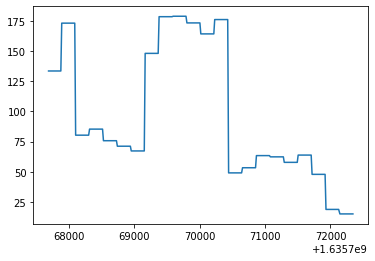

In [9]:
plt.plot(df2["unix_time"], df2["CR_portion"])

In [129]:
# total_df.groupby(['status']).count()
from tqdm import tqdm
df = pd.read_csv("BZA_DF_20-21_thet.csv")
print(df.shape)
df.dropna()
print(df.shape)
# df[df["status"]!=0].to_csv("BZA_DF_OFF.csv")
df = df[df["status"] >= 0]
print(df.shape)
df = df[df["CR_stereo"] > 1]
print(df.shape)
df = df[(df.size_1 + df.size_2) > 80]
print(df.shape)
# for nwidth in np.linspace(1.6, 2.2, 50):
#     z = df[df["nwidth"] < nwidth]
# print(df.shape)
#     ON = z.groupby(["status"])["Nevent_1"].count().values[0]
#     OFFs = z.groupby(["status"])["Nevent_1"].count().values[1:6]
#     plt.scatter(nwidth, sigma(ON, OFFs), c='r')
sigmamax = 0
nwidths = np.linspace(1.6, 2.2, 50)
size1s  = np.arange(80, 150, 4)
size2s = np.arange(100, 150, 3)
stereo_rates = np.linspace(0.8, 2, 20)
Nback = np.arange(5, 6)
for back in Nback:
    print(back)
    for nwidth in tqdm(nwidths):
        for size1 in size1s:
            for size2 in size2s:
                for stereo_rate in stereo_rates:
                    z = df.loc[(df["nwidth"] < nwidth) 
                               & (df["size_1"] > size1)
                               & (df["size_2"] > size2)
                               & (df["CR_stereo"] > stereo_rate)]
                    ON = z.groupby(["status"])["Nevent_1"].count().values[0]
                    OFFs = z.groupby(["status"])["Nevent_1"].count().values[1:6]
                    if sigma(ON, OFFs) > sigmamax:
                        sigmamax = sigma(ON, OFFs)
                        thresholds = {"nwidth":nwidth, "size_1":size1, "size_2":size2, "stereo_rate":stereo_rate, "back":back}
        print(thresholds, sigmamax)
    print(sigmamax)
    print(thresholds)
print(z.loc[0].values[0], z.loc[1:].values)
sigma(z.loc[0].values[0], z.loc[1].values)
# sigma(ON, OFFs)

(132189, 30)
(132189, 30)
(4011, 30)
(3830, 30)
(3830, 30)
5


  2%|▏         | 1/50 [00:10<08:44, 10.71s/it]

{'nwidth': 1.6, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.34367169831173533


  4%|▍         | 2/50 [00:21<08:29, 10.62s/it]

{'nwidth': 1.6, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.34367169831173533


  6%|▌         | 3/50 [00:31<08:16, 10.57s/it]

{'nwidth': 1.6244897959183675, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.3638243379904205


  8%|▊         | 4/50 [00:42<08:06, 10.57s/it]

{'nwidth': 1.6244897959183675, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.3638243379904205


 10%|█         | 5/50 [00:53<07:59, 10.65s/it]

{'nwidth': 1.6244897959183675, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.3638243379904205


 12%|█▏        | 6/50 [01:03<07:46, 10.61s/it]

{'nwidth': 1.6612244897959185, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.3836973251012605


 14%|█▍        | 7/50 [01:14<07:35, 10.59s/it]

{'nwidth': 1.6734693877551021, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.4483358396622203


 16%|█▌        | 8/50 [01:24<07:23, 10.56s/it]

{'nwidth': 1.6734693877551021, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.4483358396622203


 18%|█▊        | 9/50 [01:35<07:14, 10.59s/it]

{'nwidth': 1.6734693877551021, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.4483358396622203


 20%|██        | 10/50 [01:45<07:02, 10.57s/it]

{'nwidth': 1.7102040816326531, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.4673595648458451


 22%|██▏       | 11/50 [01:56<06:51, 10.56s/it]

{'nwidth': 1.7224489795918367, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7426484481618819


 24%|██▍       | 12/50 [02:06<06:41, 10.56s/it]

{'nwidth': 1.7346938775510206, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7592566023652966


 26%|██▌       | 13/50 [02:17<06:29, 10.52s/it]

{'nwidth': 1.7346938775510206, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7592566023652966


 28%|██▊       | 14/50 [02:27<06:17, 10.50s/it]

{'nwidth': 1.7346938775510206, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7592566023652966


 30%|███       | 15/50 [02:38<06:07, 10.49s/it]

{'nwidth': 1.7346938775510206, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7592566023652966


 32%|███▏      | 16/50 [02:48<05:57, 10.50s/it]

{'nwidth': 1.7346938775510206, 'size_1': 148, 'size_2': 103, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7592566023652966


 34%|███▍      | 17/50 [02:59<05:47, 10.53s/it]

{'nwidth': 1.795918367346939, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7657869973847099


 36%|███▌      | 18/50 [03:10<05:37, 10.54s/it]

{'nwidth': 1.8081632653061226, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.7829032083994565


 38%|███▊      | 19/50 [03:20<05:26, 10.54s/it]

{'nwidth': 1.8204081632653062, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.8690397721180617


 40%|████      | 20/50 [03:31<05:16, 10.55s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 42%|████▏     | 21/50 [03:41<05:05, 10.54s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 44%|████▍     | 22/50 [03:52<04:55, 10.55s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 46%|████▌     | 23/50 [04:03<04:48, 10.68s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 48%|████▊     | 24/50 [04:14<04:42, 10.86s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 50%|█████     | 25/50 [04:24<04:28, 10.75s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 52%|█████▏    | 26/50 [04:35<04:15, 10.66s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 54%|█████▍    | 27/50 [04:45<04:03, 10.59s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 56%|█████▌    | 28/50 [04:57<04:00, 10.93s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 58%|█████▊    | 29/50 [05:08<03:49, 10.92s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 60%|██████    | 30/50 [05:19<03:39, 10.96s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 62%|██████▏   | 31/50 [05:30<03:27, 10.92s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 64%|██████▍   | 32/50 [05:41<03:16, 10.89s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 66%|██████▌   | 33/50 [05:52<03:08, 11.08s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 68%|██████▊   | 34/50 [06:04<03:01, 11.32s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 70%|███████   | 35/50 [06:16<02:54, 11.62s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 72%|███████▏  | 36/50 [06:29<02:44, 11.76s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 74%|███████▍  | 37/50 [06:40<02:32, 11.70s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 76%|███████▌  | 38/50 [06:52<02:20, 11.75s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 78%|███████▊  | 39/50 [07:04<02:08, 11.71s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 80%|████████  | 40/50 [07:14<01:53, 11.34s/it]

{'nwidth': 1.83265306122449, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.1789473684210527, 'back': 5} 0.9770204301916486


 82%|████████▏ | 41/50 [07:25<01:39, 11.11s/it]

{'nwidth': 2.089795918367347, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.0380684981717496


 84%|████████▍ | 42/50 [07:35<01:27, 10.92s/it]

{'nwidth': 2.089795918367347, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.0380684981717496


 86%|████████▌ | 43/50 [07:46<01:15, 10.80s/it]

{'nwidth': 2.1142857142857143, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.0940050451313743


 88%|████████▊ | 44/50 [07:56<01:04, 10.73s/it]

{'nwidth': 2.1142857142857143, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.0940050451313743


 90%|█████████ | 45/50 [08:07<00:53, 10.68s/it]

{'nwidth': 2.1142857142857143, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.0940050451313743


 92%|█████████▏| 46/50 [08:17<00:42, 10.62s/it]

{'nwidth': 2.1142857142857143, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.0940050451313743


 94%|█████████▍| 47/50 [08:28<00:31, 10.58s/it]

{'nwidth': 2.1142857142857143, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.0940050451313743


 96%|█████████▌| 48/50 [08:38<00:21, 10.56s/it]

{'nwidth': 2.1755102040816325, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.1008951243478948


 98%|█████████▊| 49/50 [08:49<00:10, 10.57s/it]

{'nwidth': 2.1755102040816325, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.1008951243478948


100%|██████████| 50/50 [09:00<00:00, 10.81s/it]

{'nwidth': 2.1755102040816325, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5} 1.1008951243478948
1.1008951243478948
{'nwidth': 2.1755102040816325, 'size_1': 148, 'size_2': 148, 'stereo_rate': 1.0526315789473686, 'back': 5}


KeyError: 0

(130886, 30)
(130886, 30)
(3820, 30)
(3207, 30)
(3207, 30)
(2283, 30)


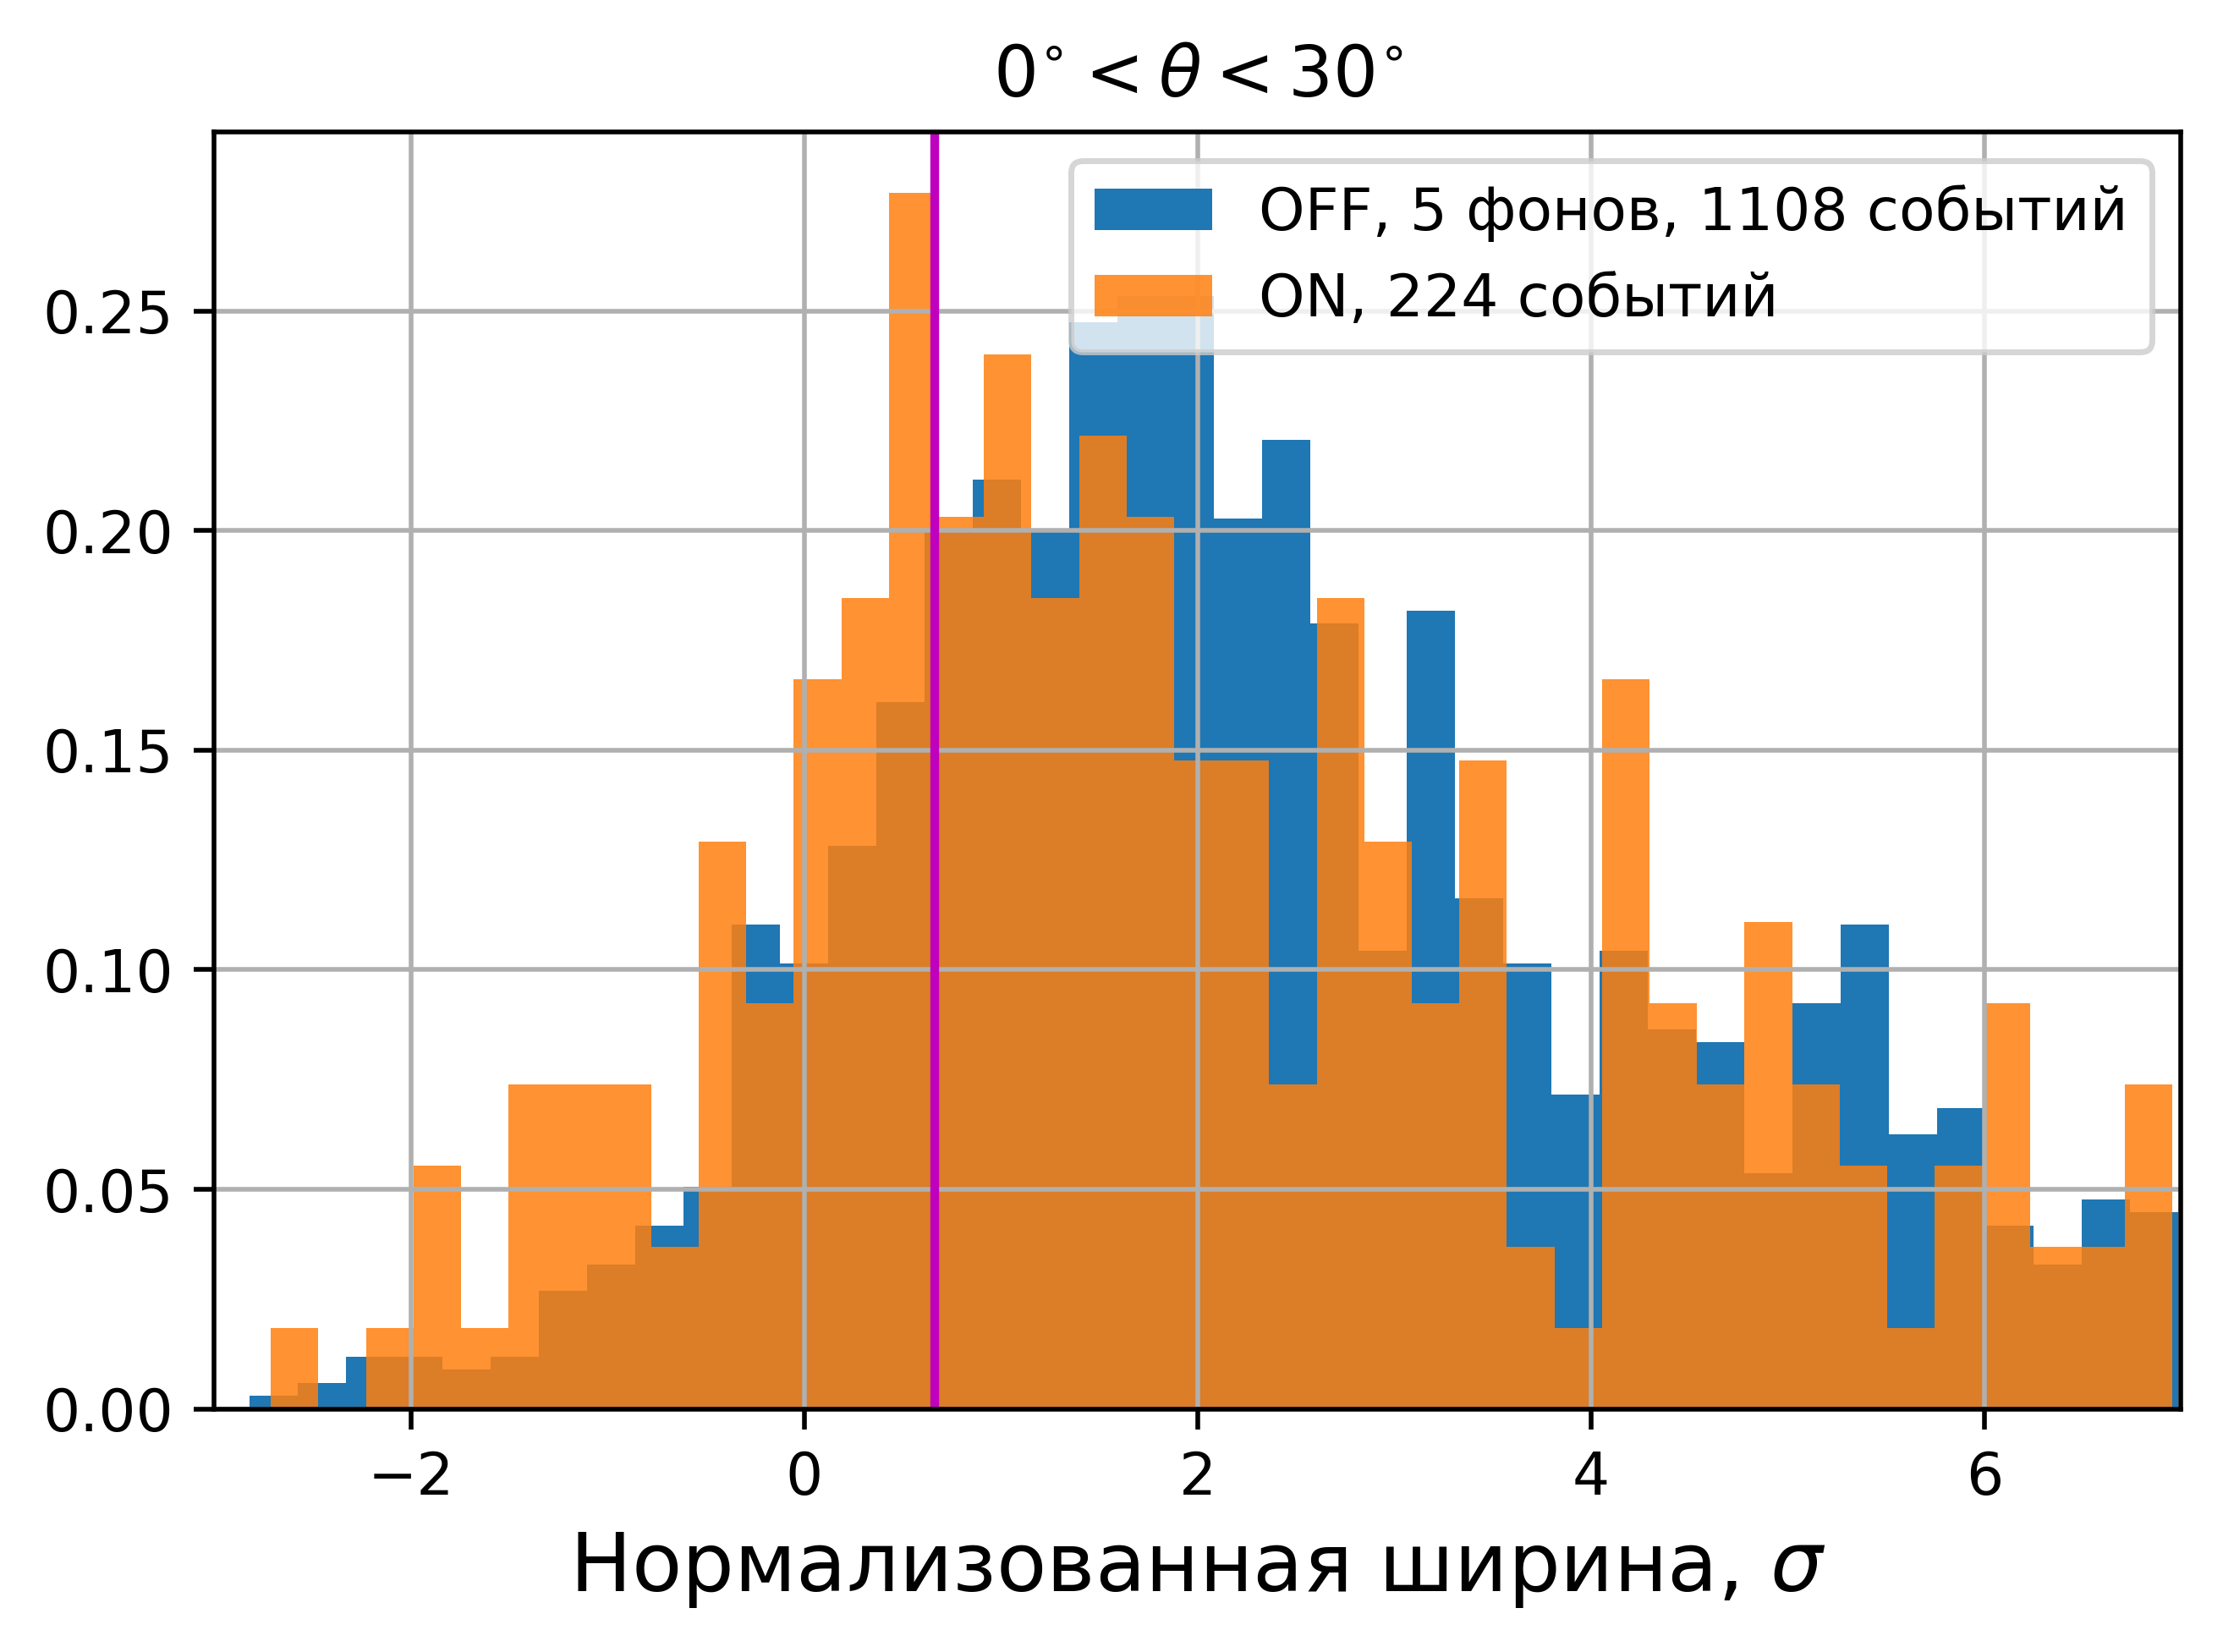

In [5]:
df = pd.read_csv("LZA_DF_20-21_thet.csv")
print(df.shape)
plt.rcParams.update({'font.size': 10})
df.dropna()
print(df.shape)
df = df[df["status"] >= 0]
print(df.shape)
df = df[df["CR_stereo"] > 1.3]
print(df.shape)
df = df[(df.size_1 + df.size_2) > 100]
print(df.shape)
df = df[(df.nwidth > -3) & (df.nwidth < 7)]
print(df.shape)
# for nwidth in np.linspace(1.2, 1.4, 50):
#     z = df[df["nwidth"] < nwidth]
# # print(df.shape)
#     ON = z.groupby(["status"])["Nevent_1"].count().values[0]
#     OFFs = z.groupby(["status"])["Nevent_1"].count().values[1:3]
#     plt.scatter(nwidth, sigma(ON, OFFs), c='r')

fig, ax = plt.subplots(dpi=500)

ON = df.groupby(["status"])["Nevent_1"].count().values[0]
OFFs = df.groupby(["status"])["Nevent_1"].count().values[1:6]
ax.grid("--")
ax.hist(df[(df["status"] >= 1)& (df["status"] <= 6)].nwidth, alpha=1,
        bins = 40, label=f"OFF, 5 фонов, {np.sum(OFFs)} событий", density=True)
ax.hist(df[df["status"] == 0].nwidth, bins = 40, label=f"ON, {ON} событий", alpha=0.85, density=True)
ax.axvline(x=0.665, c = 'm')

ax.set_xlim(-3, 7)
ax.legend()
ax.set_xlabel(r"Нормализованная ширина, $\sigma$", fontsize=14)
ax.set_title(r"$0^{\circ} < \theta < 30^{\circ}$")
plt.savefig("LZA.svg", format='svg')

(132189, 30)
(132189, 30)
(4011, 30)
(3814, 30)
(1928, 30)
(1378, 30)


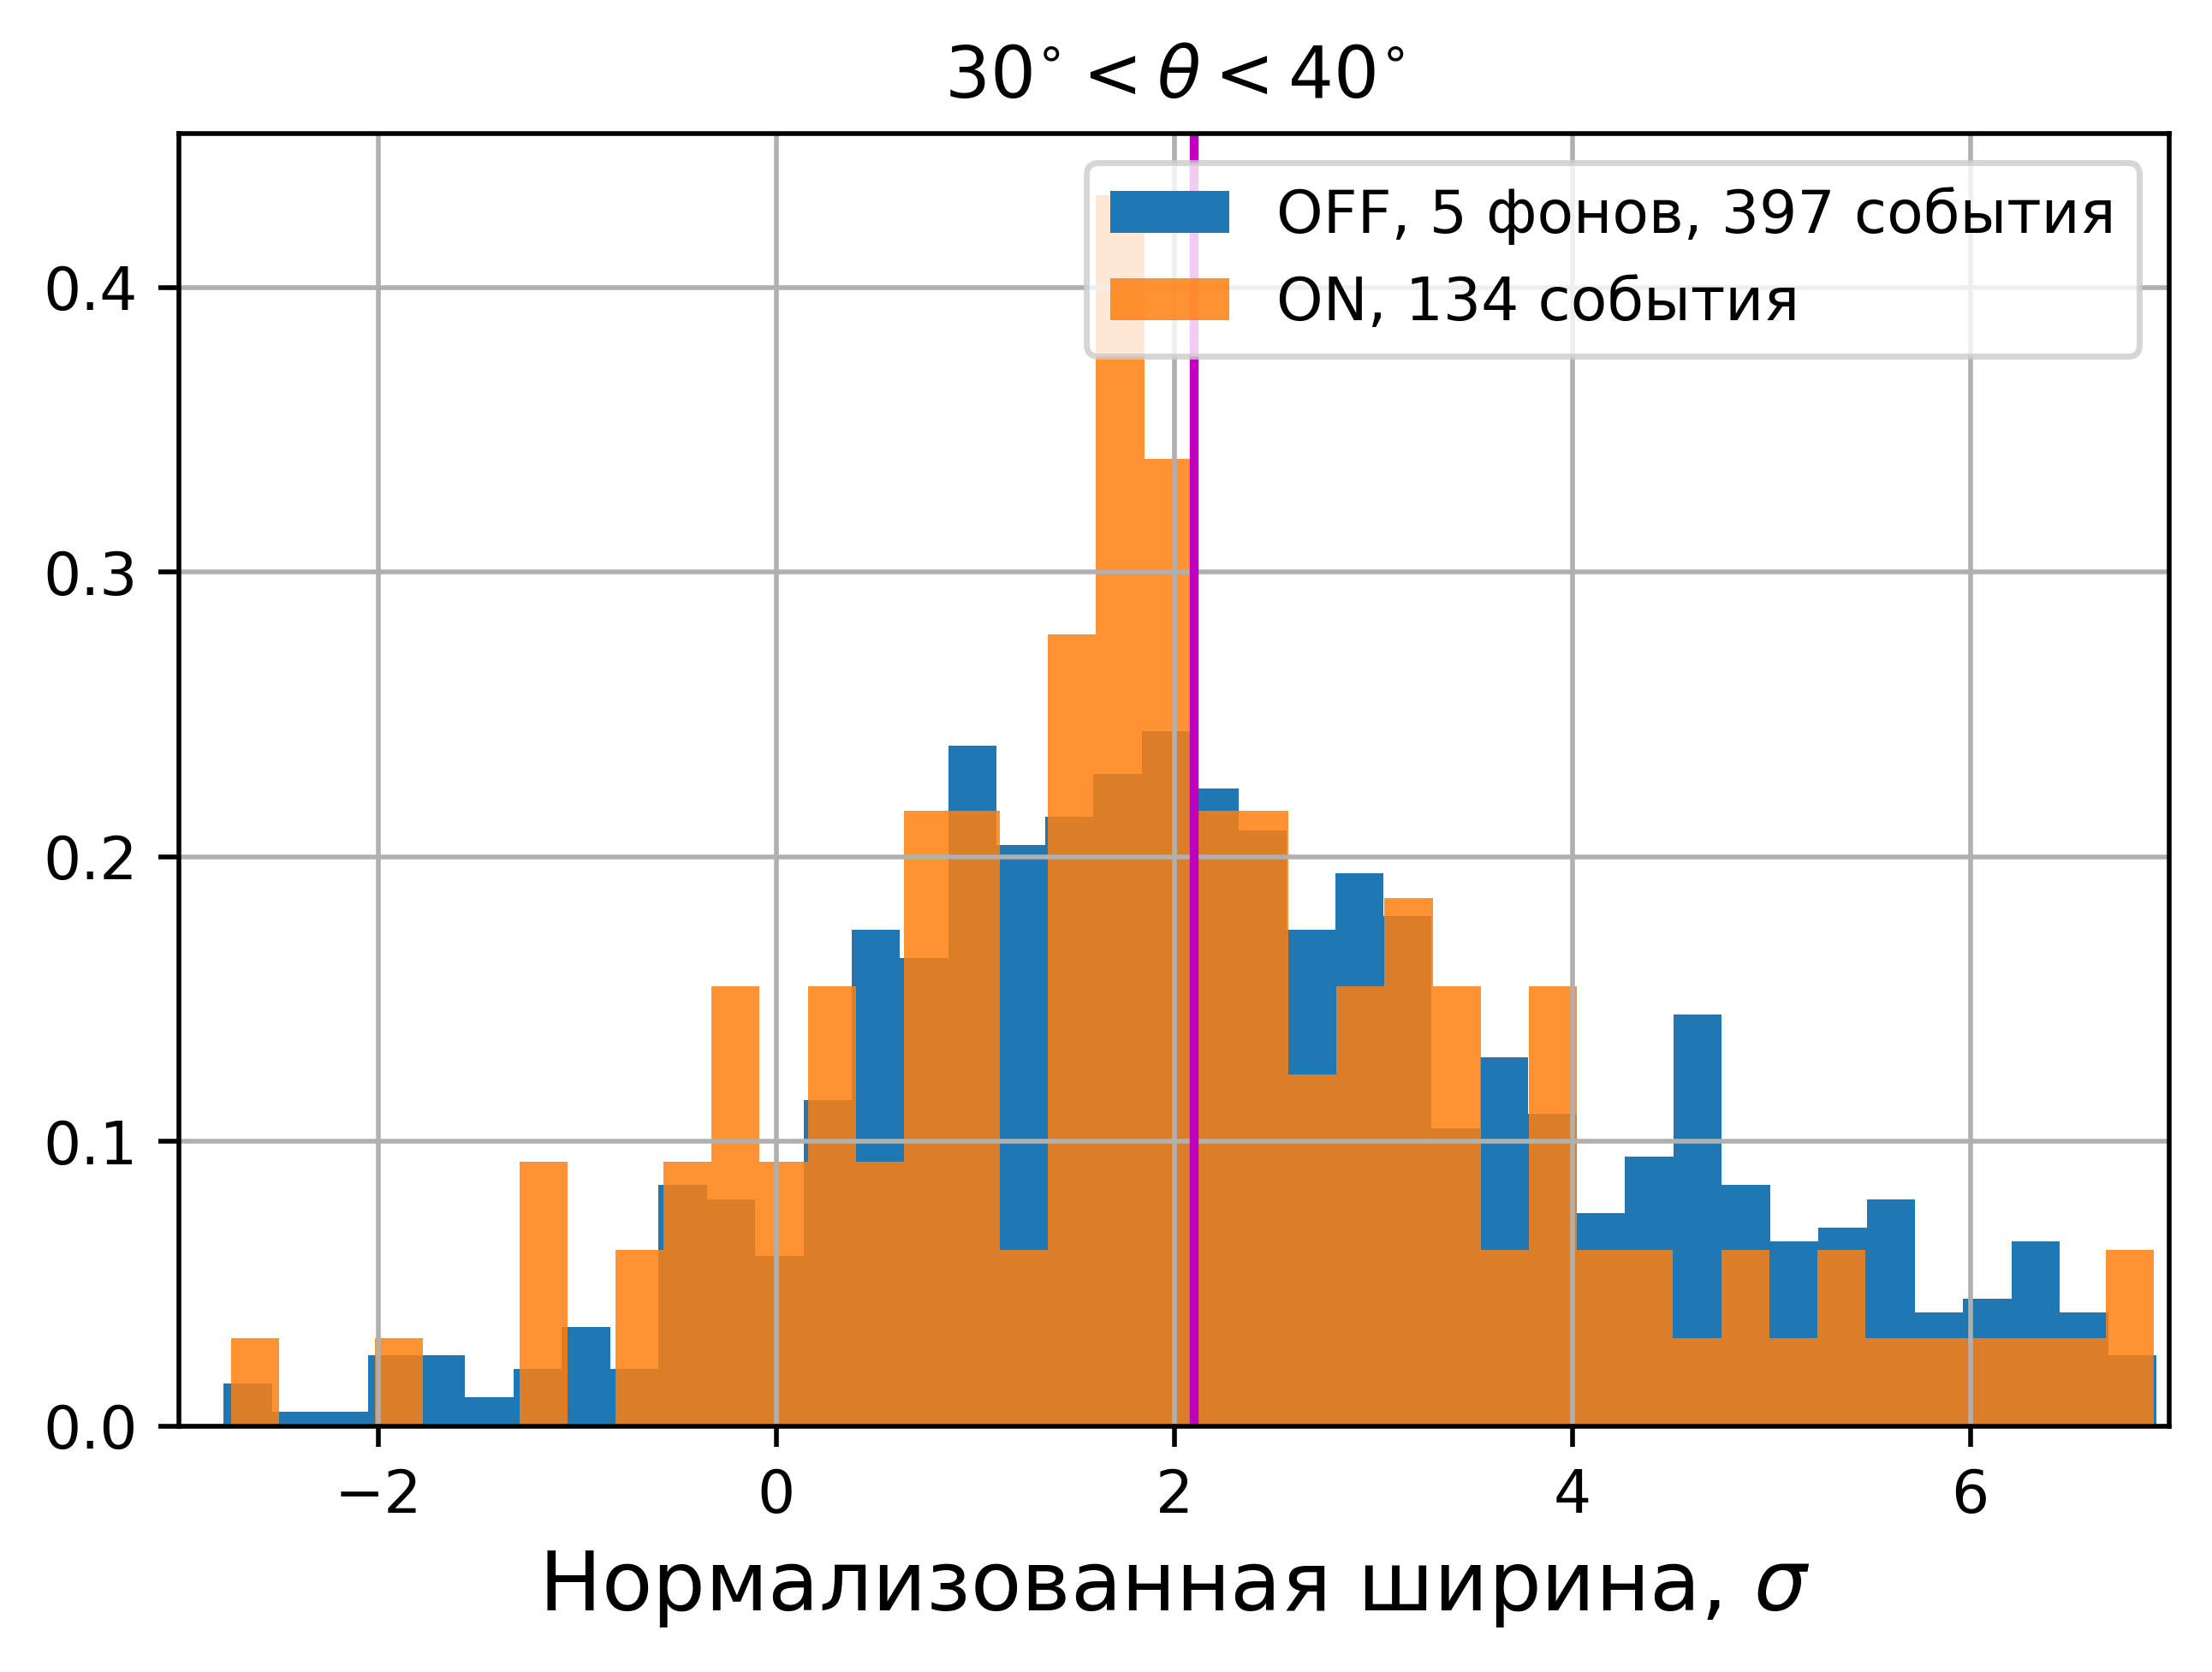

In [4]:
df = pd.read_csv("BZA_DF_20-21_thet.csv")
print(df.shape)
plt.rcParams.update({'font.size': 10})
df.dropna()
print(df.shape)
df = df[df["status"] >= 0]
print(df.shape)
df = df[df["CR_stereo"] > 1.05]
print(df.shape)
df = df[(df.size_1 > 148) & (df.size_2 > 148)]
print(df.shape)
df = df[(df.nwidth > -3) & (df.nwidth < 7)]
print(df.shape)
# for nwidth in np.linspace(1.2, 1.4, 50):
#     z = df[df["nwidth"] < nwidth]
# # print(df.shape)
#     ON = z.groupby(["status"])["Nevent_1"].count().values[0]
#     OFFs = z.groupby(["status"])["Nevent_1"].count().values[1:3]
#     plt.scatter(nwidth, sigma(ON, OFFs), c='r')

fig, ax = plt.subplots(dpi=500)

ON = df.groupby(["status"])["Nevent_1"].count().values[0]
OFFs = df.groupby(["status"])["Nevent_1"].count().values[1:4]
ax.grid("--")
ax.hist(df[(df["status"] >= 1)& (df["status"] <= 6)].nwidth, alpha=1,
        bins = 40, label=f"OFF, 5 фонов, {np.sum(OFFs)} события", density=True)
ax.hist(df[df["status"] == 0].nwidth, bins = 40, label=f"ON, {ON} события", alpha=0.85, density=True)
ax.axvline(x=2.1, c = 'm')

ax.set_xlim(-3, 7)
ax.legend()
ax.set_xlabel(r"Нормализованная ширина, $\sigma$", fontsize=14)
ax.set_title(r"$30^{\circ} < \theta < 40^{\circ}$")
plt.savefig("BZA.svg", format='svg')

2.0
72 59.0 1.3578057164544433
2.013157894736842
72 59.666666666666664 1.2866160634783341
2.026315789473684
72 60.0 1.2510864843424487
2.039473684210526
73 60.333333333333336 1.3126882181215866
2.0526315789473686
73 60.333333333333336 1.3126882181215866
2.0657894736842106
73 61.0 1.2421180068162376
2.0789473684210527
74 61.0 1.3384765349564314
2.0921052631578947
76 61.333333333333336 1.4934573132646871
2.1052631578947367
76 61.666666666666664 1.4586750928384307
2.1184210526315788
77 62.0 1.5178123290484906
2.1315789473684212
77 62.333333333333336 1.4832396974191324
2.1447368421052633
77 63.333333333333336 1.3797598556789321
2.1578947368421053
78 63.666666666666664 1.4389401350320477
2.1710526315789473
79 64.33333333333333 1.4634182315230269
2.1842105263157894
79 64.66666666666667 1.429368364926247
2.1973684210526314
80 66.0 1.3862065601673441
2.2105263157894735
80 66.66666666666667 1.3187609467915735
2.223684210526316
80 67.33333333333333 1.2514633516836904
2.236842105263158
80 67.3333

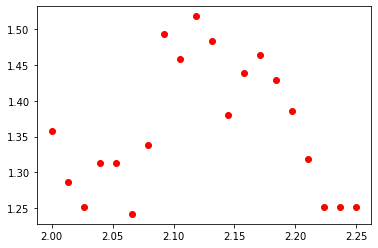

In [208]:
for nwidth in np.linspace(2., 2.25, 20):
    z = df[df["nwidth"] < nwidth]
    print(nwidth)
# print(df.shape)
    ON = z.groupby(["status"])["Nevent_1"].count().values[0]
    OFFs = z.groupby(["status"])["Nevent_1"].count().values[1:4]
    print(ON, np.mean(OFFs), sigma(ON, OFFs))
    plt.scatter(nwidth, sigma(ON, OFFs), c='r')
# np.linspace(0.5, 1.4, 50)

Text(0.5, 1.0, '$0^{\\circ} < \\theta < 30^{\\circ}$')

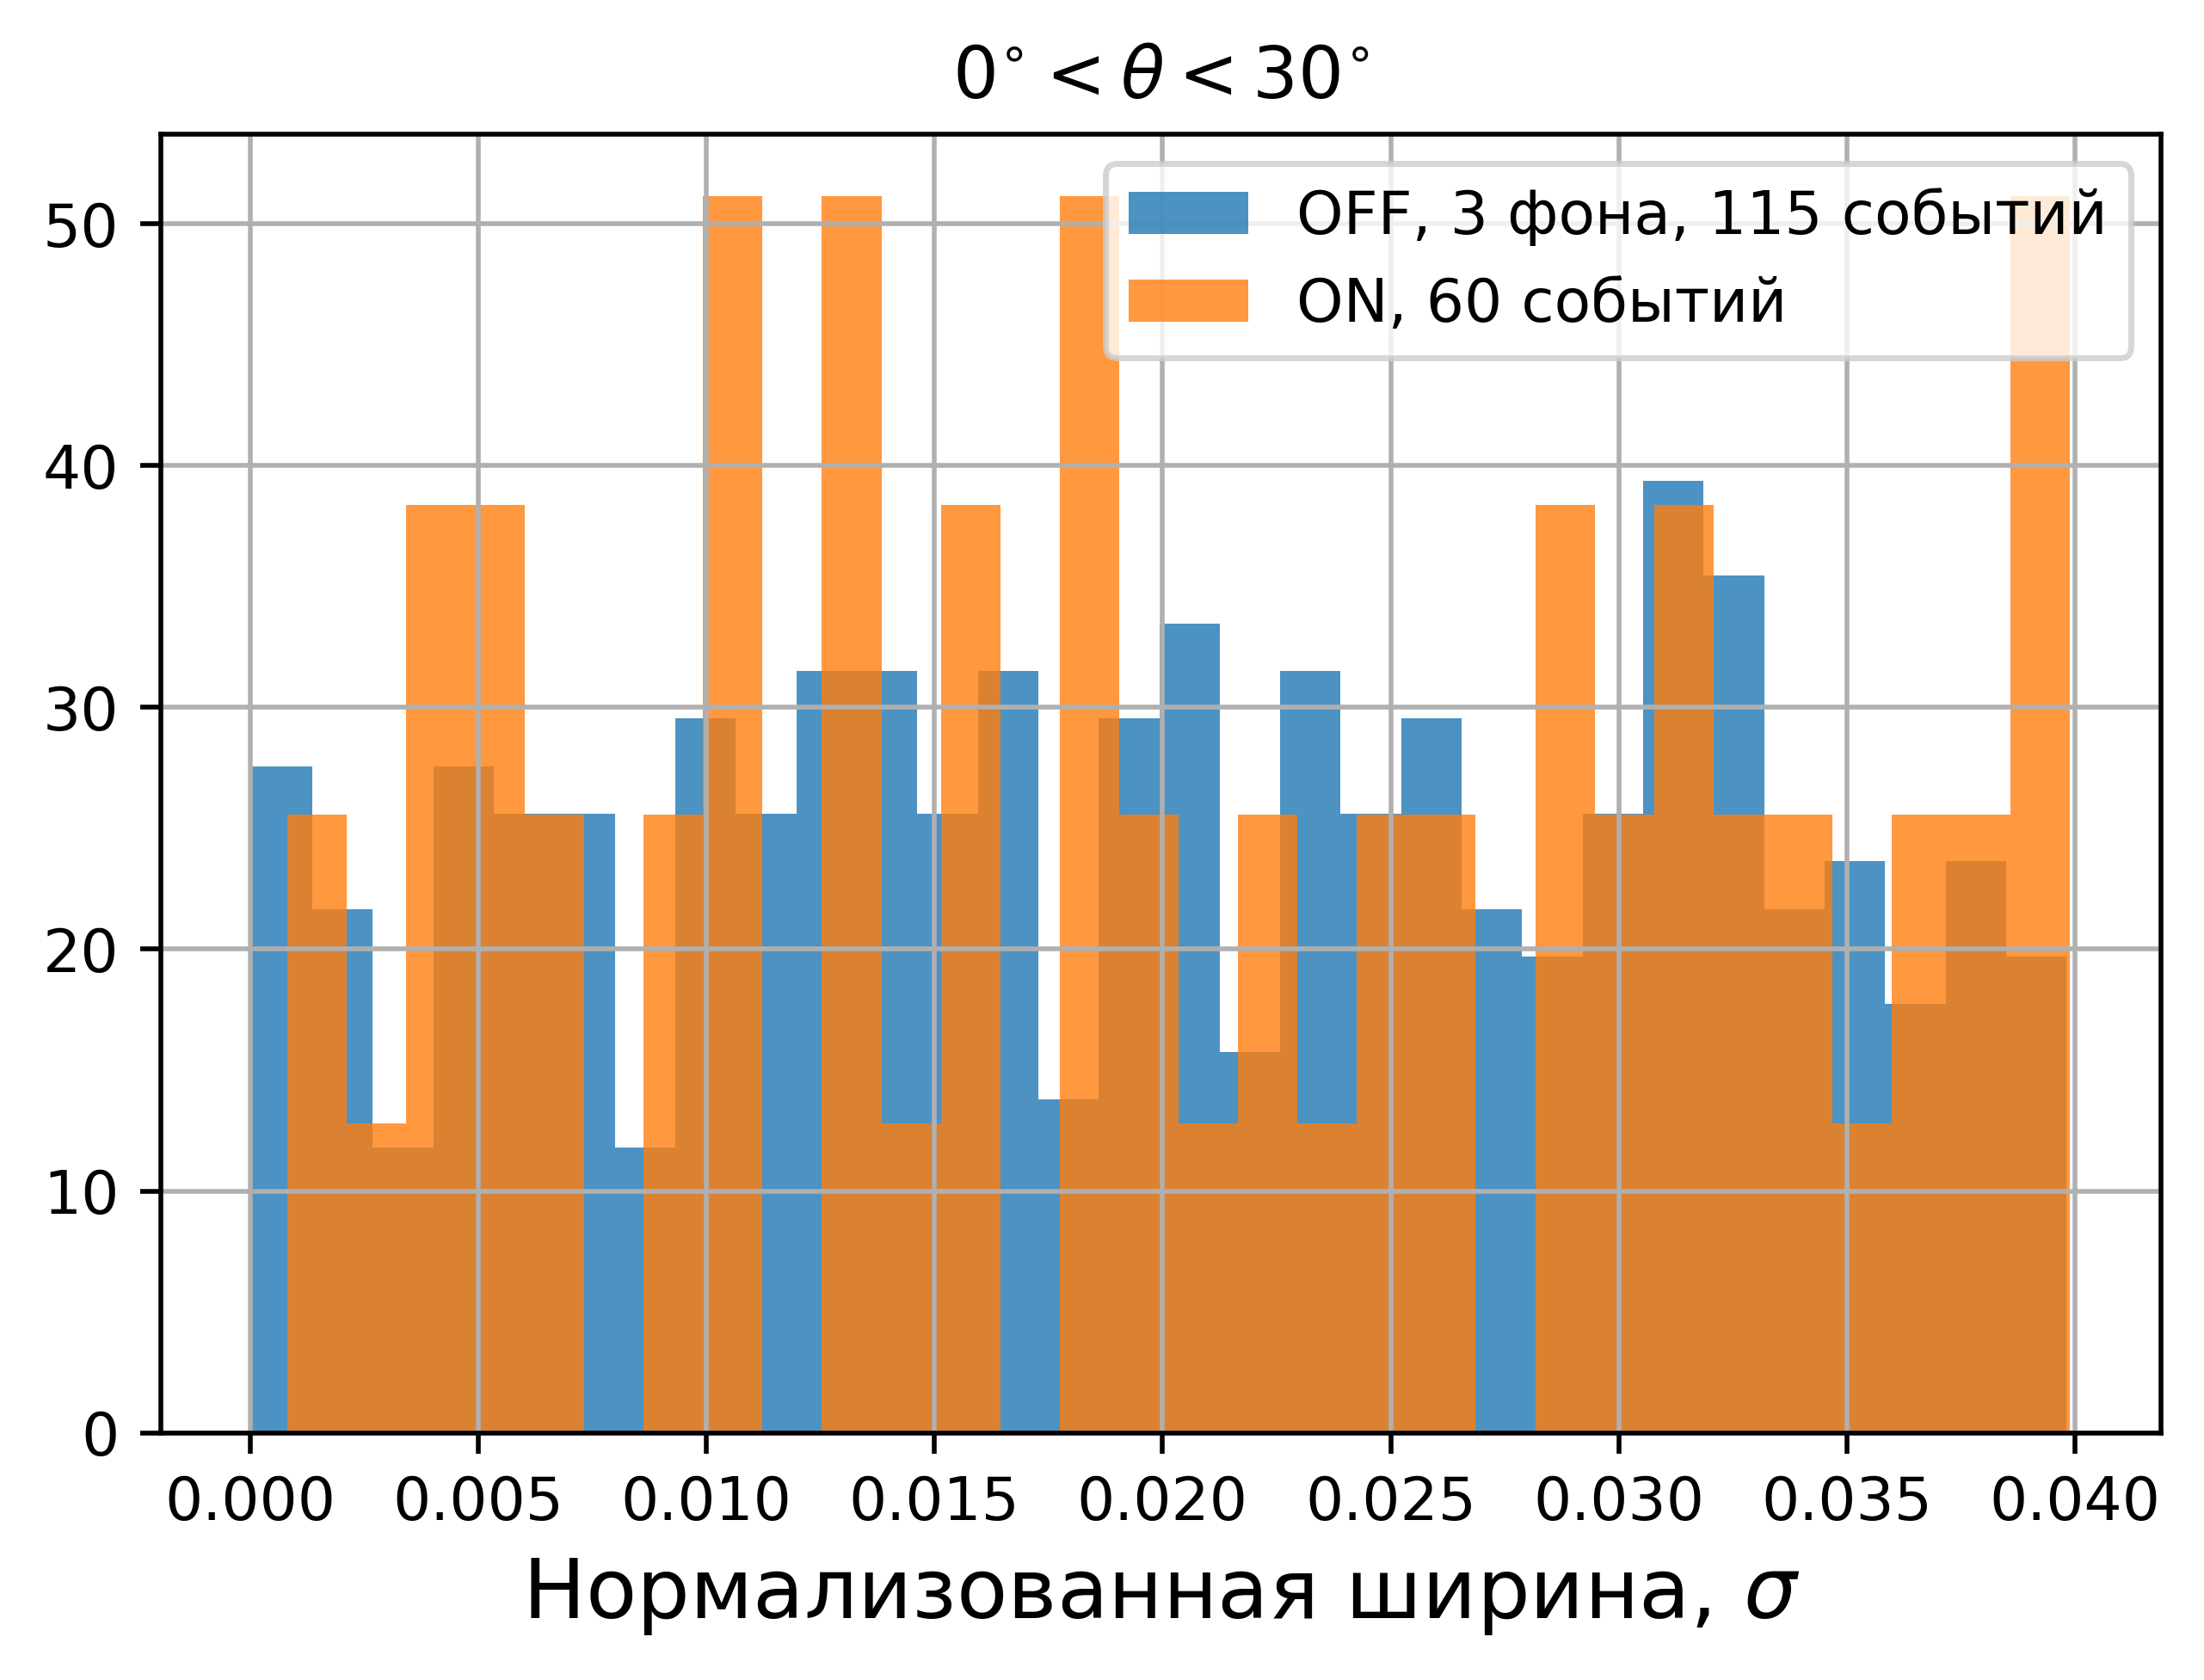

In [105]:
fig, ax = plt.subplots(dpi=500)
df = df[df.nwidth < 0.6]
ON = df.groupby(["status"])["Nevent_1"].count().values[0]
OFFs = df.groupby(["status"])["Nevent_1"].count().values[1:4]
ax.grid("--")
ax.hist(df[(df["status"] >= 1)].errorON**2, alpha=0.8,
        bins = 30, label=f"OFF, 3 фона, {np.sum(OFFs)} событий", density=True)
ax.hist(df[df["status"] == 0].errorON**2, bins = 30, label=f"ON, {ON} событий", alpha=0.8, density=True)
# ax.axvline(x=1.29, c = 'm')

# ax.set_xlim(-3, 7)
ax.legend()
ax.set_xlabel(r"Нормализованная ширина, $\sigma$", fontsize=14)
ax.set_title(r"$0^{\circ} < \theta < 30^{\circ}$")

In [25]:
np.degrees(np.arctan(4.5/8))

29.357753542791276

In [209]:
sigma(77+66, np.ones(5)*38 + np.ones(5)*62)

3.368019934948217

In [ ]:
plt.hist(z.size_2, log=True, bins = 100)

In [ ]:
stats = pd.read_csv("stats_2.txt", delim_whitespace=True)
stats[(stats["Ntel"] >= 2)]

In [ ]:
# pd.Series(stereo_event).index
# pd.concat([pd.DataFrame(stereo_event).T, pd.DataFrame(stereo_event).T], ignore_index = True)
# plt.plot(stereo_df["zenith"])
plt.plot(cuts[0]["unix_time"], cuts[0]["tel_az"])
plt.plot(cuts[0]["unix_time"], cuts[1]["tel_az"])
# plt.plot(cuts[0]["unix_time"], cuts[0]["source_el"])
# plt.plot(cuts[0]["unix_time"], cuts[1]["source_el"])

In [ ]:
# total_df[total_df["status"] == 0].count(), total_df[total_df["status"] > 0].count() / 7
total_df

In [ ]:
sigma(30, 17.1, 7)
# 180 - np.degrees(np.arccos(1.36/1.44))
# 0.8/np.sqrt(3.44)

In [ ]:
NWS =  np.array([0.50, 0.60, 0.63, 0.65, 0.67, 0.70, 0.73, 0.80, 0.90, 1.00, 1.05, 1.10, 1.15, 1.20, 1.30, 1.40, 1.50, 1.60])
NONs = np.array([30.0, 33.0, 34.0, 34.0, 35.0, 36.0, 36.0, 36.0, 39.0, 39.0, 40.0, 42.0, 46.0, 46.0, 48.0, 49.0, 53.0, 55.0])
NOFs = np.array([17.1, 18.9, 19.6, 20.1, 20.3, 20.4, 21.1, 22.4, 24.7, 26.9, 27.8, 29.1, 29.8, 31.2, 32.7, 35.3, 37.3, 39.1])


# NWS = np.array([0.5, 0.60, 0.63, 0.65, 0.70, 0.80, 0.90, 1.00, 1.05, 1.10, 1.13, 1.14, 1.15, 1.16, 1.17, 1.20, 1.25, 1.30, 1.40, 1.50, 1.60, 2.00])
# NONs = np.array([24., 26., 27.,  27.,  29.,  29.,  32.,  32.,  33.,  35.,  36.,  39.,  40.,  40.,  40.,  40.,  42.,  42.,  44.,  49.,  51.,  54.])
# NOFs = np.array([10., 10., 11.,  12.,  13.,  14.,  14.,  15.,  16.,  17.,  17.,  17.,  17.,  18.,  19.,  20.,  20.,  21.,  22.,  26.,  28.,  33.])

# NONs = np.array([28., 32.0, 36.0, 38.0, 41.0, 42.0, 45.0, 46.0, 46.0, 46.0, 46.0, 48.0, 49.0, 50.0, 55.0, 58.0, 59.0]) #для зенитных углов 30--40
# NOFs = np.array([15., 16.0, 18.0, 20.0, 21.0, 22.0, 22.0, 22.0, 23.0, 24.0, 25.0, 28.0, 29.0, 32.0, 37.0, 39.0, 49.0])
# NWS = np.array([0.80, 0.90, 1.00, 1.05, 1.10, 1.13, 1.14, 1.15, 1.16, 1.17, 1.20, 1.25, 1.30, 1.40, 1.50, 1.60, 2.00])

def sigma_error(ON, OFF, n=1):
#     if ON + OFF:
#         return (0.5 * 
#                 np.sqrt(ON ** 3 + 15 * (ON**2) * OFF + 15 * ON * (OFF**2) + OFF ** 3)
#                 /np.sqrt(ON ** 3 + 3 * (ON**2) * OFF + 3 * ON * (OFF**2) + OFF ** 3))
    x = ON
    y = OFF
    a1 = (n*y * (y / n + x) * (2*n*x + x + y) ** 2)/(4 * (n*x + y) ** 4)
    a2 = (x * (n * (x + y)+2*y)**2)/(4*(n*x + y) ** 2 * (y / n + x))
    return np.sqrt(a1 + a2)

# SGS = np.array([1.98, 2.31, 2.45, 2.36, 2.54, 2.50, 2.81, 2.91, 2.77, 2.63, 2.49, 2.19, 2.06, 1.98, 1.88, 1.98])
SGS = np.array([sigma(NONs[i], float(NOFs[i]), 7) for i in range(len(NONs))])
SES = np.array([sigma_error(NONs[i], NOFs[i], 7) for i in range(len(NONs))])
print(SES)
# plt.scatter(NWS[:-1], SGS[:-1])
plt.errorbar(NWS, SGS, yerr = SES, fmt = 'o')
plt.grid()
plt.xlabel("Normalized width")
plt.ylabel(r"$\sigma(N_{ON}, N_{OFF})$")
plt.title(r"Zenith angles $30-40\degree, t=22.5h$")
plt.title(r"Zenith angles $<30\degree, t=20.1h$")

In [ ]:
df = pd.read_csv("events.stereo.csv")
df1 = pd.DataFrame(cuts[0])
df2 = pd.DataFrame(cuts[1])
# df1[(df1["size"] > 120) & (df1["dist[0]"] < 3.5) & (df1["source_el"] > 47.5)]
# df[:20]
df

In [ ]:
total_cutted_ON, total_events, total_time / 3600

In [ ]:
total_events/total_time

In [ ]:
cuts_new = [dfs[tel].iloc[joint_selected[tel]] for tel in range(2)]
cuts_new[0]

In [ ]:
# plt.plot(cuts[0]["unix_time"], cuts[0]["CR_portion"]/np.sin(np.radians(cuts[0]["tel_el"])))
plt.plot(cuts[0]["unix_time"], cuts[0]["stereo_rate"])
# plt.plot(cuts[1]["unix_time"], cuts[1]["CR_portion"]/np.sin(np.radians(cuts[1]["tel_el"])))
# plt.scatter(cuts[0]["unix_time"], 10*np.ones(len(cuts[0])))
# plt.hist(cuts[0].delta_time, bins = Nbins, log = True)
# plt.hist(cuts[1].delta_time, bins = Nbins, log = True)
# plt.hist(cuts[0]["unix_time"], bins = 50)

In [ ]:
plt.hist(nwidths, bins = 2*Nbins )
plt.xlim(-5, 5)
# np.histogram(nwidths, bins = Nbins)
nwidths = np.array(nwidths)
len(nwidths[nwidths < 0.3])/len(nwidths)

In [ ]:
# events_selected[15].vizualize()
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

pov1, pov2, _, _, _ = events_selected[6].data
ground_x, ground_y, tel_coord_tilted = ground_intersect(pov1, pov2, tel_coord)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(tel_coord[0], tel_coord[1], [0, 0], c = 'r')
ax.scatter(tel_coord_tilted[0], tel_coord_tilted[1], tel_coord_tilted[2], c = 'g')

print(tel_coord)
print(tel_coord_tilted)
# print(pov1.width, pov2.width, norm_width(scalewidth, (pov1, pov2), tel_coord, ground_x, ground_y))
# plt.xlim(-400, 150)
# plt.ylim(-300, 200)

Source at 0.834 0.885
Intersect at -0.659 1.897
Axis determination error is 1.804


<AxesSubplot:>

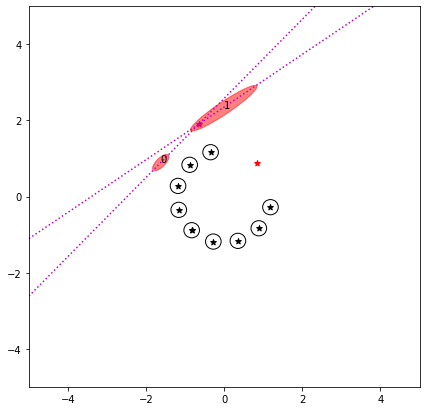

In [74]:
# print(e.x, e.y, intersect(pov1, pov2))
# print(eudist((-1.312, -1.308), (-1.294, 0.462)))
# print(X, Y)
# print(eudist((X, Y), (e.x, e.y)))
e.vizualize()

In [ ]:
np.nan